# Variational Autoencoder (VAE)

In this notebook, we create a "simple" VAE for dimensionality reduction.

We used count matrix of 151508, 151669 and 151673 samples from DLPFC dataset. We also apply VAE on the top 300 HGV gene (300 columns of count matrix).

The results are used in **ARI.ipynb** script. The aim is to compare clustering performance of reducted data from latent space of AE or VAE.

# Import packages

pip install umap-learn

In [2]:
!pip install -q tensorflow==2.1
!pip install -q keras==2.3.1

In [3]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2023-07-19 12:38:26.413680: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2023-07-19 12:38:26.413887: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2023-07-19 12:38:26.413906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.1.0 2.3.1


Using TensorFlow backend.


In [4]:
import os
import pandas as pd
import numpy as np
import scipy

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import matplotlib.pyplot as plt
import argparse

from numpy.random import seed
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import losses

# for visualization
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import TSNE

ModuleNotFoundError: No module named 'umap'

# Functions definition

Scale function :

In [2]:
def scale_datasets(x):
    """Standard Scale test and train data.
    
    Parameters
    ----------
    x : pandas dataframe
       count matrix

    Returns
    -------
    x_sclaed : pandas dataframe
        normalized count matrix
    """
    standard_scaler = MinMaxScaler()
    x_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x),
      columns=x.columns
    )
    return x_scaled

Sampling : 

In [5]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    
    Parameters
    ----------
    args : tensor
        mean and log of variance of Q(z|X)

    Returns
    -------
    z : tensor
        sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
     

Custom loss function :

In [6]:
# As in the Keras tutorial, we define a custom loss function:
def vae_loss(x, x_decoded_mean):
    """Define a custom loss function.

    Parameters
    ----------
    x : Dense layer
    x_decoded_mean : decoded mean

    Returns
    -------
    xent_loss + kl_loss
    """
    xent_loss = keras.losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

Visualization :

In [1]:
def compute_dimensionality_reduction(df, df_meta, method):
    """Compute dimensionality reduction.

    With PCA, UMAP or T-SNE for visualization.

    Parameters
    ----------
    df : pandas dataframe
        dataframe to use for DR
    df_meta : pandas dataframe
        original datafrale
    method : string
        Choose DR method

    Returns
    -------
    pandas dataframe
        df_metha with X1 and X2 columns
    """
    if method == 'PCA':
        pca = PCA(n_components = 2)
        reduced = pca.fit_transform(df)
    
    if method == 'TSNE':
        tsne = TSNE(n_components = 2)
        reduced = tsne.fit_transform(df)
    
    if method == 'UMAP':
        umap_method = umap.UMAP()
        reduced = umap_method.fit_transform(df)
    
    df_reduced = pd.DataFrame({'X1': reduced[:, 0], 'X2': reduced[:, 1]})
    
    return pd.concat([df_meta, df_reduced], axis=1)

# 1. DLPFC dataset

## 1.1. 151508

In [7]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/DPLFC_151508_counts_with_probes.csv", index_col=0)
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])

In [8]:
x_scaled = scale_datasets(counts_wo_xy)

In [9]:
# network parameters
original_dim = x_scaled.shape[1]
input_shape = (original_dim, )
intermediate_dim = 300
batch_size = 128
latent_dim = 10
epochs = 10

In [10]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x) 

2023-07-19 09:42:24.042928: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-07-19 09:42:46.388064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 09:42:46.389599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:17.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2023-07-19 09:42:46.389703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 09:42:46.391138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 1 with properties: 
pciBusID: 0000:00:18.0 n

In [11]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [12]:
encoder = Model(inputs, z_mean)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 33538)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               10061700  
_________________________________________________________________
z_mean (Dense)               (None, 10)                3010      
Total params: 10,064,710
Trainable params: 10,064,710
Non-trainable params: 0
_________________________________________________________________


In [13]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)  

In [14]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               3300      
_________________________________________________________________
dense_3 (Dense)              (None, 33538)             10094938  
Total params: 10,098,238
Trainable params: 10,098,238
Non-trainable params: 0
_________________________________________________________________


In [15]:
outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='vae_mlp')

In [16]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [17]:
results = vae.fit(x_scaled, x_scaled,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)#,
       # validation_data=(x_test, x_test))

Epoch 1/10
 128/4384 [..............................] - ETA: 16s - loss: 0.6998

2023-07-19 09:42:48.977080: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


4384/4384 [==============================] - 6s 1ms/step - loss: 0.6364
Epoch 2/10
4384/4384 [==============================] - 6s 1ms/step - loss: 0.1766
Epoch 3/10
4384/4384 [==============================] - 6s 1ms/step - loss: 0.0905
Epoch 4/10
4384/4384 [==============================] - 6s 1ms/step - loss: 0.0653
Epoch 5/10
4384/4384 [==============================] - 6s 1ms/step - loss: 0.0551
Epoch 6/10
4384/4384 [==============================] - 6s 1ms/step - loss: 0.0511
Epoch 7/10
4384/4384 [==============================] - 6s 1ms/step - loss: 0.0497
Epoch 8/10
4384/4384 [==============================] - 6s 1ms/step - loss: 0.0490
Epoch 9/10
4384/4384 [==============================] - 6s 1ms/step - loss: 0.0486
Epoch 10/10
4384/4384 [==============================] - 6s 1ms/step - loss: 0.0484


In [19]:
data_w = x_scaled
data_y = x_scaled

In [20]:
test_au_features = encoder.predict(data_w)

In [21]:
df = pd.DataFrame(test_au_features, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,-0.006707,0.005637,-0.003031,0.005136,0.003856,-0.004012,-0.005671,0.006491,-0.006154,0.005494
1,-0.021789,0.027955,-0.030739,0.024700,0.033570,-0.017187,-0.027266,0.011224,-0.025461,0.022327
2,-0.015198,0.026562,-0.028059,0.022637,0.022804,-0.020222,-0.032830,0.014714,-0.021327,0.018314
3,-0.015970,0.016333,-0.016652,0.014815,0.021307,-0.008936,-0.013530,0.007395,-0.016462,0.014628
4,-0.006707,0.005637,-0.003031,0.005136,0.003856,-0.004012,-0.005671,0.006491,-0.006154,0.005494


In [22]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space_VAE"
os.makedirs(sevenbg_output_path, exist_ok=True)
df.to_csv(f"{sevenbg_output_path}/DPLFC_151508_latent_space_VAE.csv")

## 1.2. 151669

In [23]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/DPLFC_151669_counts_with_probes.csv", index_col=0)
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])

In [24]:
x_scaled = scale_datasets(counts_wo_xy)

In [25]:
# network parameters
original_dim = x_scaled.shape[1]
input_shape = (original_dim, )
intermediate_dim = 300
batch_size = 128
latent_dim = 10
epochs = 10

In [26]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x) 

In [27]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [28]:
encoder = Model(inputs, z_mean)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 33538)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               10061700  
_________________________________________________________________
z_mean (Dense)               (None, 10)                3010      
Total params: 10,064,710
Trainable params: 10,064,710
Non-trainable params: 0
_________________________________________________________________


In [29]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)  

In [30]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               3300      
_________________________________________________________________
dense_6 (Dense)              (None, 33538)             10094938  
Total params: 10,098,238
Trainable params: 10,098,238
Non-trainable params: 0
_________________________________________________________________


In [31]:
outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='vae_mlp')

In [32]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [33]:
results = vae.fit(x_scaled, x_scaled,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)#,
       # validation_data=(x_test, x_test))

Epoch 1/10
3661/3661 [==============================] - 5s 1ms/step - loss: 0.9638
Epoch 2/10
3661/3661 [==============================] - 5s 1ms/step - loss: 0.2609
Epoch 3/10
3661/3661 [==============================] - 5s 1ms/step - loss: 0.1346
Epoch 4/10
3661/3661 [==============================] - 5s 1ms/step - loss: 0.0932
Epoch 5/10
3661/3661 [==============================] - 5s 1ms/step - loss: 0.0760
Epoch 6/10
3661/3661 [==============================] - 5s 1ms/step - loss: 0.0684
Epoch 7/10
3661/3661 [==============================] - 5s 1ms/step - loss: 0.0660
Epoch 8/10
3661/3661 [==============================] - 5s 1ms/step - loss: 0.0648
Epoch 9/10
3661/3661 [==============================] - 5s 1ms/step - loss: 0.0642
Epoch 10/10
3661/3661 [==============================] - 5s 1ms/step - loss: 0.0635


In [34]:
data_w = x_scaled
data_y = x_scaled

In [35]:
test_au_features = encoder.predict(data_w)

In [36]:
df = pd.DataFrame(test_au_features, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,0.044081,0.019462,-0.038333,0.016076,0.020363,0.023822,0.024654,-0.019562,-0.029043,-0.004226
1,0.064549,0.023235,-0.053068,0.015106,0.021429,0.020894,0.030364,-0.023850,-0.038337,0.003634
2,0.099608,0.029698,-0.078309,0.013443,0.023255,0.015879,0.040145,-0.031194,-0.054256,0.017097
3,0.055606,0.021587,-0.046630,0.015530,0.020963,0.022173,0.027869,-0.021976,-0.034277,0.000199
4,0.043836,0.019417,-0.038156,0.016088,0.020350,0.023857,0.024585,-0.019510,-0.028932,-0.004320


In [37]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space_VAE"
os.makedirs(sevenbg_output_path, exist_ok=True)
df.to_csv(f"{sevenbg_output_path}/DPLFC_151669_latent_space_VAE.csv")

## 1.3. 151673

In [5]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/DPLFC_151673_counts_with_probes.csv", index_col=0)
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])

In [65]:
counts

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,y_coord,x_coord
probes,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8468,9791
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2807,5769
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9505,4068
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4151,9271
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7583,3393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9396,5653
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9630,4825
TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7831,4631


In [40]:
x_scaled = scale_datasets(counts_wo_xy)

In [41]:
# network parameters
original_dim = x_scaled.shape[1]
input_shape = (original_dim, )
intermediate_dim = 300
batch_size = 128
latent_dim = 10
epochs = 10

In [42]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x) 

In [43]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [44]:
encoder = Model(inputs, z_mean)
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 33538)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               10061700  
_________________________________________________________________
z_mean (Dense)               (None, 10)                3010      
Total params: 10,064,710
Trainable params: 10,064,710
Non-trainable params: 0
_________________________________________________________________


In [45]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)  

In [46]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               3300      
_________________________________________________________________
dense_9 (Dense)              (None, 33538)             10094938  
Total params: 10,098,238
Trainable params: 10,098,238
Non-trainable params: 0
_________________________________________________________________


In [47]:
outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='vae_mlp')

In [48]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [49]:
results = vae.fit(x_scaled, x_scaled,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)#,
       # validation_data=(x_test, x_test))

Epoch 1/10
3639/3639 [==============================] - 5s 1ms/step - loss: 1.0011
Epoch 2/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.2689
Epoch 3/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.1438
Epoch 4/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.1030
Epoch 5/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.0856
Epoch 6/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.0777
Epoch 7/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.0758
Epoch 8/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.0746
Epoch 9/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.0734
Epoch 10/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.0732


In [50]:
data_w = x_scaled
data_y = x_scaled

In [51]:
test_au_features = encoder.predict(data_w)

In [52]:
df = pd.DataFrame(test_au_features, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,-0.016775,0.022148,0.022815,0.025259,-0.026727,0.019226,-0.030279,-0.02473,0.018883,-0.020151
1,-0.028213,0.037775,0.050461,0.034461,-0.043317,0.034772,-0.045205,-0.02814,0.024419,-0.044863
2,-0.016775,0.022148,0.022815,0.025259,-0.026727,0.019226,-0.030279,-0.02473,0.018883,-0.020151
3,-0.016775,0.022148,0.022815,0.025259,-0.026727,0.019226,-0.030279,-0.02473,0.018883,-0.020151
4,-0.016775,0.022148,0.022815,0.025259,-0.026727,0.019226,-0.030279,-0.02473,0.018883,-0.020151


In [53]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space_VAE"
os.makedirs(sevenbg_output_path, exist_ok=True)
df.to_csv(f"{sevenbg_output_path}/DPLFC_151673_latent_space_VAE.csv")

# 2. Visualize 151673 result with DR

## 2.1. PCA

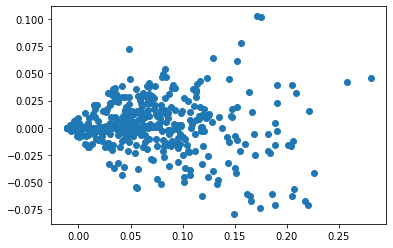

In [61]:
df_embeddings_pca = compute_dimensionality_reduction(test_au_features, x_scaled, method = 'PCA')
plt.scatter(df_embeddings_pca["X1"], df_embeddings_pca["X2"])

## 2.2. UMAP

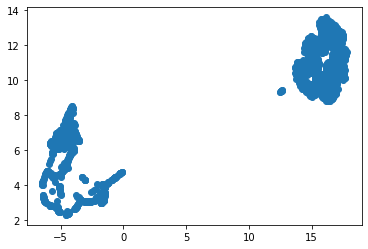

In [62]:
df_embeddings_umap = compute_dimensionality_reduction(test_au_features, x_scaled, method = 'UMAP')
plt.scatter(df_embeddings_umap["X1"], df_embeddings_umap["X2"])

## 2.3. T-SNE

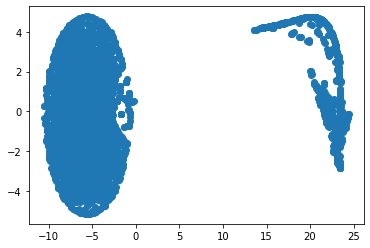

In [63]:
df_embeddings_tsne = compute_dimensionality_reduction(test_au_features, x_scaled, method = 'TSNE')
plt.scatter(df_embeddings_tsne["X1"], df_embeddings_tsne["X2"])

# 3. VAE with Top 300 HVG 151673

Import dataframe:

In [ ]:
HGV_300_151673 = pd.read_csv("/../../sbgenomics/project-files/HVG/151673_300_HGV.csv", index_col = 0)
HGV_300_151673_list = HGV_300_151673.index.values.tolist()

In [ ]:
HGV_300_151673

In [79]:
HGV_counts_151673 = x_scaled[HGV_300_151673_list]
HGV_counts_151673

,NPY,PLP1,IGKC,HBB,HBA2,MBP,SST,IGHG3,CNP,CRYAB,...,RASSF2,SLC10A7,SLAIN1,TEC,VSIG1,AC025580.3,AL590434.1,C21orf62-AS1,AC017007.5,GFI1B
0,0.000000,0.047297,0.056338,0.000000,0.019231,0.051282,0.013699,0.000000,0.020833,0.000000,...,0.142857,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.019231,0.015385,0.013699,0.000000,0.020833,0.000000,...,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.297297,0.014085,0.048780,0.057692,0.523077,0.000000,0.000000,0.312500,0.500000,...,0.142857,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001639,0.013514,0.000000,0.000000,0.019231,0.030769,0.013699,0.000000,0.000000,0.021739,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.027027,0.112676,0.000000,0.000000,0.066667,0.000000,0.190476,0.062500,0.108696,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,0.000000,0.675676,0.000000,0.024390,0.000000,0.251282,0.000000,0.000000,0.770833,0.413043,...,0.571429,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3635,0.000000,0.182432,0.056338,0.243902,0.038462,0.230769,0.000000,0.000000,0.291667,0.282609,...,0.142857,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3636,0.000000,0.094595,0.000000,0.000000,0.000000,0.138462,0.013699,0.000000,0.020833,0.043478,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3637,0.000000,0.074324,0.000000,0.000000,0.000000,0.158974,0.000000,0.000000,0.041667,0.108696,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# network parameters
original_dim = x_scaled.shape[1]
input_shape = (original_dim, )
intermediate_dim = 300
batch_size = 128
latent_dim = 10
epochs = 10

In [82]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x) 

In [83]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [84]:
encoder = Model(inputs, z_mean)
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 33538)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 300)               10061700  
_________________________________________________________________
z_mean (Dense)               (None, 10)                3010      
Total params: 10,064,710
Trainable params: 10,064,710
Non-trainable params: 0
_________________________________________________________________


In [85]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)  

In [86]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               3300      
_________________________________________________________________
dense_12 (Dense)             (None, 33538)             10094938  
Total params: 10,098,238
Trainable params: 10,098,238
Non-trainable params: 0
_________________________________________________________________


In [87]:
outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='vae_mlp')

In [88]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [89]:
results = vae.fit(x_scaled, x_scaled,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)#,
       # validation_data=(x_test, x_test))

Epoch 1/10
3639/3639 [==============================] - 5s 1ms/step - loss: 15.8450
Epoch 2/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.5588
Epoch 3/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.2297
Epoch 4/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.1519
Epoch 5/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.1473
Epoch 6/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.1403
Epoch 7/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.1144
Epoch 8/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.1012
Epoch 9/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.0963
Epoch 10/10
3639/3639 [==============================] - 5s 1ms/step - loss: 0.0927


In [90]:
data_w = x_scaled
data_y = x_scaled

In [91]:
test_au_features = encoder.predict(data_w)

In [92]:
df = pd.DataFrame(test_au_features, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,-0.197893,0.034987,0.073894,0.093073,0.047538,0.059292,-0.080315,-0.271451,-0.370838,0.279535
1,0.028109,0.033638,0.054317,0.074342,-0.010094,0.087897,0.008102,-0.118148,-0.112070,0.092338
2,-0.113476,0.051329,0.091132,0.122331,0.083065,0.074624,-0.095899,-0.277277,-0.190900,0.187419
3,-0.090264,0.005339,0.069125,0.104059,0.014023,0.112809,-0.080549,-0.258041,-0.282034,0.213093
4,-0.046267,-0.019858,0.026249,0.152955,0.000633,0.025900,-0.040721,-0.220377,-0.208973,0.177776


In [93]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space_VAE"
os.makedirs(sevenbg_output_path, exist_ok=True)
df.to_csv(f"{sevenbg_output_path}/HGV_DPLFC_151673_latent_space_VAE.csv")